In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
import gpt as g

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.qcd.dirac import dirac_wilson_clover
from qcd_ml.base.paths import PathBuffer

from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice

from qcd_ml.util.solver import GMRES_restarted

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: pc1011901129
--------------------------------------------------------------------------


SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

/home/knd35666/.local/lib/python3.12/site-packages/torch/_inductor/lowering.py:1612: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


In [2]:
class Smoother_PTC(torch.nn.Module):
    def __init__(self, U, r_relaxation):
        super().__init__()
        self.U = U
        self.paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]
        layers = [v_PTC(2, 2, self.paths, self.U) for _ in range(2 * (r_relaxation-1))]
        self.layers = torch.nn.ModuleList(layers 
                                  + [
                                        v_PTC(2, 2, self.paths, self.U)
                                        , v_PTC(2, 1, self.paths, self.U)]
                                 )

    def forward(self, v):
        for l in self.layers:
            v = l.forward(v)
        return v


In [3]:

U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)


w = dirac_wilson_clover(U, -0.58, 1.0)

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.58,
    "csw_r": 1.0,
    "csw_t": 1.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))

GPT :       5.792430 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :       5.804861 s : Switching view to [1,1,1,1]/Read
GPT :       6.116853 s : Read 0.00109863 GB at 0.00352122 GB/s (0.00406568 GB/s for distribution, 0.0262973 GB/s for reading + checksum, 0.738107 GB/s for checksum, 1 views per node)
GPT :       6.158830 s : Read 0.00109863 GB at 0.0265193 GB/s (0.0625051 GB/s for distribution, 0.0460694 GB/s for reading + checksum, 0.131929 GB/s for checksum, 1 views per node)
GPT :       6.199831 s : Read 0.00109863 GB at 0.0271255 GB/s (0.0624196 GB/s for distribution, 0.0479805 GB/s for reading + checksum, 0.148243 GB/s for checksum, 1 views per node)
GPT :       6.240829 s : Read 0.00109863 GB at 0.0271437 GB/s (0.0610388 GB/s for distribution, 0.0488876 GB/s for reading + checksum, 0.183652 GB/s for checksum, 1 views per node)
GPT :       6.241289 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.453238 s


In [4]:
def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()


In [5]:
x, ret = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=500 // 20, maxiter_inner=30)
ret

{'converged': True, 'k': 636, 'res': tensor(9.9245e-05, dtype=torch.float64)}

In [6]:
weights_ptc1h1l = torch.load("ptc1h1l_start_id.pt", weights_only=True)
paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]
ptc_layer = v_PTC(1, 1, paths, U)
ptc_layer.load_state_dict(weights_ptc1h1l)

<All keys matched successfully>

In [7]:
layer = Smoother_PTC(U, 2)

In [8]:
idty = torch.complex(torch.tensor(np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))
zeros = torch.complex(torch.zeros((4,4), dtype=torch.double)
                     , torch.zeros((4,4), dtype=torch.double))

for li in layer.layers:
    li.weights.data[:,:,:] = zeros
    li.weights.data[:,:,0] = idty

In [9]:
def iterative_uk(ukm1, b, Mh, D):
    result = b
    result = result - D(ukm1)
    result = Mh(result)
    result = ukm1 + result
    return result

def ukn(b, Mh, D, n):
    uk = torch.zeros_like(b)
    
    for k in range(n):
        uk = iterative_uk(uk, b, Mh, D)
    return uk

In [ ]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)
zero = torch.zeros_like(vec)

n_training = 1000
check_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)

    with torch.no_grad():
        outp = torch.stack([
            ukn(vec, lambda x: ptc_layer.forward(torch.stack([x]))[0], w, 0+2)
        ])
        inp = torch.stack([
            vec, ukn(vec, lambda x: ptc_layer.forward(torch.stack([x]))[0], w, 0+0)
        ])

    scale = l2norm(inp[0])
    inp = inp / scale
    outp = outp / scale
    
    score = complex_mse_loss(layer.forward(inp), outp)
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_restarted(w, vec, vec
                                         , prec=lambda v: layer.forward(torch.stack([v, vec]))[0]
                                         , eps=1e-4, max_restart=20, maxiter_inner=30)
    
        iterations_p[t // check_every - 1] = ret_p["k"]
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    
print()
plt.plot(loss)
plt.yscale("log")

W0731 17:16:43.679000 140514623035200 torch/_dynamo/convert_frame.py:762] [5/8] torch._dynamo hit config.cache_size_limit (8)
W0731 17:16:43.679000 140514623035200 torch/_dynamo/convert_frame.py:762] [5/8]    function: 'v_ng_evaluate_path' (/home/knd35666/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml/src/qcd_ml/base/paths.py:26)
W0731 17:16:43.679000 140514623035200 torch/_dynamo/convert_frame.py:762] [5/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0731 17:16:43.679000 140514623035200 torch/_dynamo/convert_frame.py:762] [5/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0731 17:16:43.679000 140514623035200 torch/_dynamo/convert_frame.py:762] [5/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Text(0, 0.5, 'iterations required by GMRES')

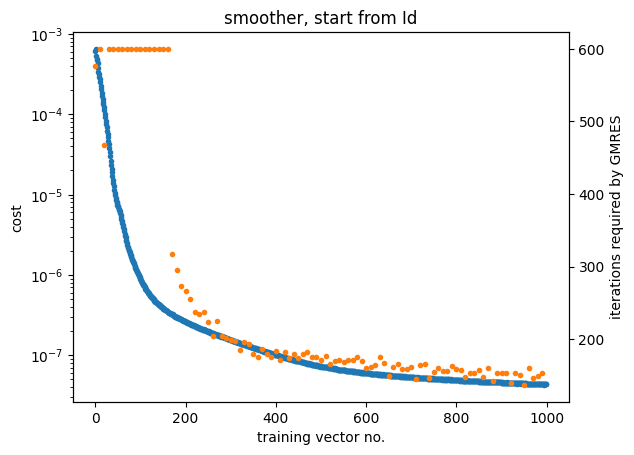

In [13]:
plt.plot(loss, ".")
plt.title("smoother, start from Id")
plt.yscale("log")
plt.ylabel("cost")
plt.xlabel("training vector no.")
ax = plt.gca().twinx()
ax.plot(np.arange(0, n_training, check_every), iterations_p, "C1.")
ax.set_ylabel("iterations required by GMRES")

In [14]:
x, ret = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=500 // 20, maxiter_inner=30)
ret

{'converged': True, 'k': 628, 'res': tensor(9.9952e-05, dtype=torch.float64)}

In [15]:
with torch.no_grad():
    x_p, ret_p = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=500 // 20, maxiter_inner=30, prec=lambda v: layer.forward(torch.stack([v, vec]))[0])

{'converged': True, 'k': 628, 'res': tensor(9.9952e-05, dtype=torch.float64)}

In [16]:
ret_p

{'converged': True, 'k': 154, 'res': tensor(9.9420e-05, dtype=torch.float64)}

In [17]:
ret["k"] / ret_p["k"]

4.077922077922078

In [18]:
torch.save(layer.state_dict(), "smoother_start_id.pt")